In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


In [6]:
movies=pd.read_csv("movies.csv")
ratings=pd.read_csv("ratings.csv")

In [7]:
print("Movies dataset:")
print(movies.head())

Movies dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [8]:
print("\nRatings dataset:")
print(ratings.head())


Ratings dataset:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [9]:
# Merge on movieId
merged = pd.merge(ratings, movies, on="movieId")
merged.head()


userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller

# Data Cleaning & Preparation

In [10]:
# Check missing values
print(merged.isnull().sum())

# Drop duplicates if present
merged = merged.drop_duplicates()

# Ensure rating is numeric
merged["rating"] = pd.to_numeric(merged["rating"], errors="coerce")

print(merged.info())


userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB
None


In [11]:
# Convert Unix timestamp to datetime
merged['timestamp'] = pd.to_datetime(merged['timestamp'], unit='s')

# Extract useful parts (year, month, day, hour)
merged['year'] = merged['timestamp'].dt.year
merged['month'] = merged['timestamp'].dt.month
merged['day'] = merged['timestamp'].dt.day


# Exploratory Data Analysis

In [12]:
# Average rating per movie + count of ratings
movie_stats = merged.groupby("title")["rating"].agg(["mean", "count"]).reset_index()

# Filter movies with at least 50 ratings (to avoid bias from few ratings)
popular_movies = movie_stats[movie_stats["count"] >= 50].sort_values("mean", ascending=False)

print(popular_movies.head(10))  # Top 10


                                                  title      mean  count
7593                   Shawshank Redemption, The (1994)  4.429022    317
3499                              Godfather, The (1972)  4.289062    192
3011                                  Fight Club (1999)  4.272936    218
1961                              Cool Hand Luke (1967)  4.271930     57
2531  Dr. Strangelove or: How I Learned to Stop Worr...  4.268041     97
6999                                 Rear Window (1954)  4.261905     84
3500                     Godfather: Part II, The (1974)  4.259690    129
2334                               Departed, The (2006)  4.252336    107
3564                                  Goodfellas (1990)  4.250000    126
1593                                  Casablanca (1942)  4.240000    100


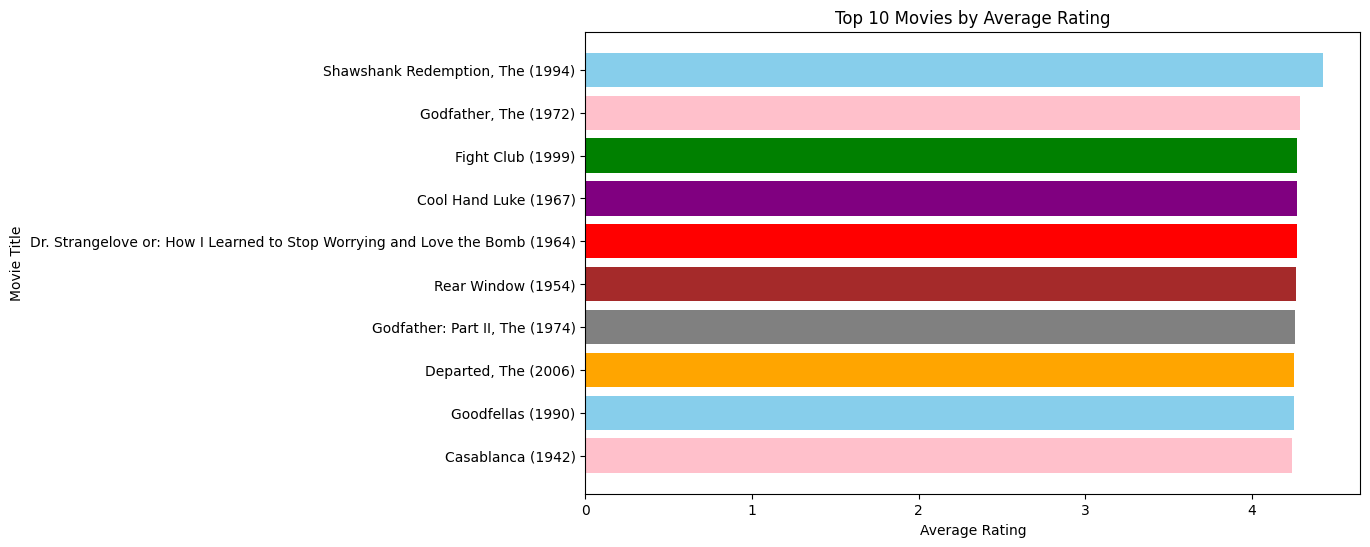


Conclusion: The graph shows the Top 10 movies with the highest average ratings. These movies are consistently rated highly and are strong candidates for recommendations.


In [13]:
top10 = popular_movies.head(10)

colors = ['skyblue', 'pink', 'green', 'purple', 'red', 
          'brown', 'gray', 'orange']

plt.figure(figsize=(10,6))
plt.barh(top10["title"], top10["mean"], color=colors)
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.title("Top 10 Movies by Average Rating")
plt.gca().invert_yaxis()
plt.show()
plt.show()

print("\nConclusion: The graph shows the Top 10 movies with the highest average ratings. "
      "These movies are consistently rated highly and are strong candidates for recommendations.")



# conclusion
The graph shows the Top 10 movies with the highest average ratings. 
These movies are consistently rated highly and are strong candidates for recommendations.

In [14]:
# Split genres into multiple rows
genre_split = merged.assign(genre=merged["genres"].str.split("|")).explode("genre")

# Count movies per genre
genre_counts = genre_split.groupby("genre")["movieId"].nunique().sort_values(ascending=False)

print(genre_counts)


genre
Drama                 4349
Comedy                3753
Thriller              1889
Action                1828
Romance               1591
Adventure             1262
Crime                 1196
Sci-Fi                 980
Horror                 977
Fantasy                778
Children               664
Animation              610
Mystery                573
Documentary            438
War                    381
Musical                333
Western                167
IMAX                   158
Film-Noir               85
(no genres listed)      34
Name: movieId, dtype: int64


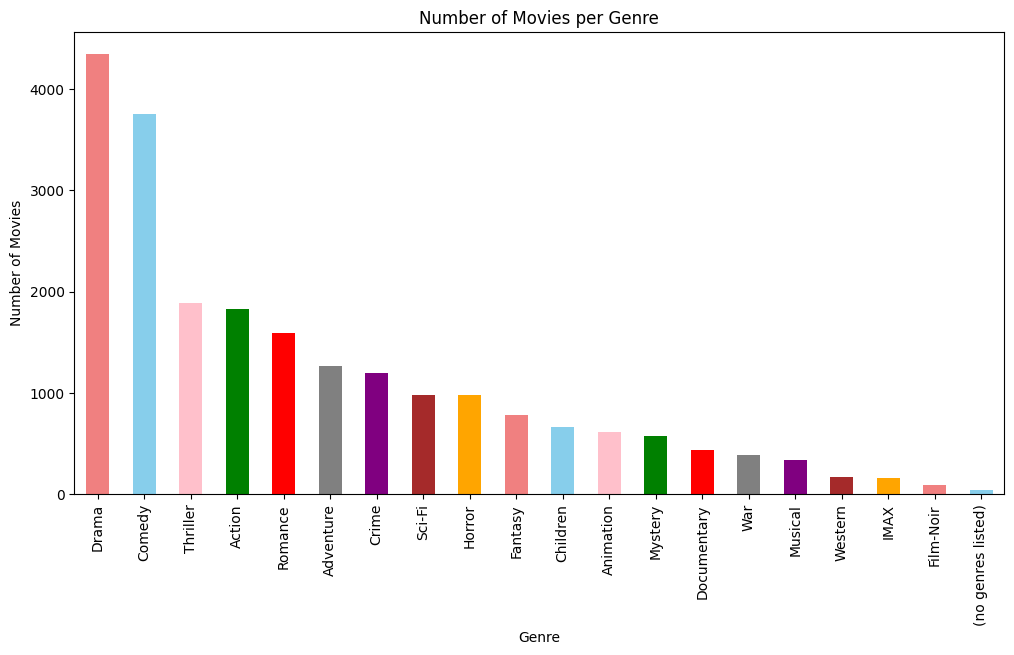

In [15]:
plt.figure(figsize=(12,6))
genre_counts.plot(kind="bar", color=['lightcoral','skyblue','pink','green','red','gray','purple','brown','orange'])
plt.title("Number of Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.show()


# Conclusion:
The bar chart shows the distribution of movies across different genres.  
Genres like Drama, Comedy, and Thriller have the highest number of movies, while Documentary and Western have fewer.  
This insight can help in recommending movies or analyzing user preferences based on genre popularity.


In [16]:
def recommend_movies_by_genre(genre, min_ratings=30, top_n=5):
    # Filter selected genre
    genre_data = genre_split[genre_split["genre"] == genre]
    
    # Compute mean rating & count
    stats = genre_data.groupby("title")["rating"].agg(["mean", "count"]).reset_index()
    
    # Filter by min ratings
    stats = stats[stats["count"] >= min_ratings]
    
    # Sort by rating
    top_movies = stats.sort_values("mean", ascending=False).head(top_n)
    return top_movies

# Example: Recommend top 5 Comedy movies
print(recommend_movies_by_genre("Comedy", min_ratings=30, top_n=5))


                                                  title      mean  count
960   Dr. Strangelove or: How I Learned to Stop Worr...  4.268041     97
2689                         Princess Bride, The (1987)  4.232394    142
2713                                Pulp Fiction (1994)  4.197068    307
149   Amelie (Fabuleux destin d'Amélie Poulain, Le) ...  4.183333    120
1181                                Forrest Gump (1994)  4.164134    329


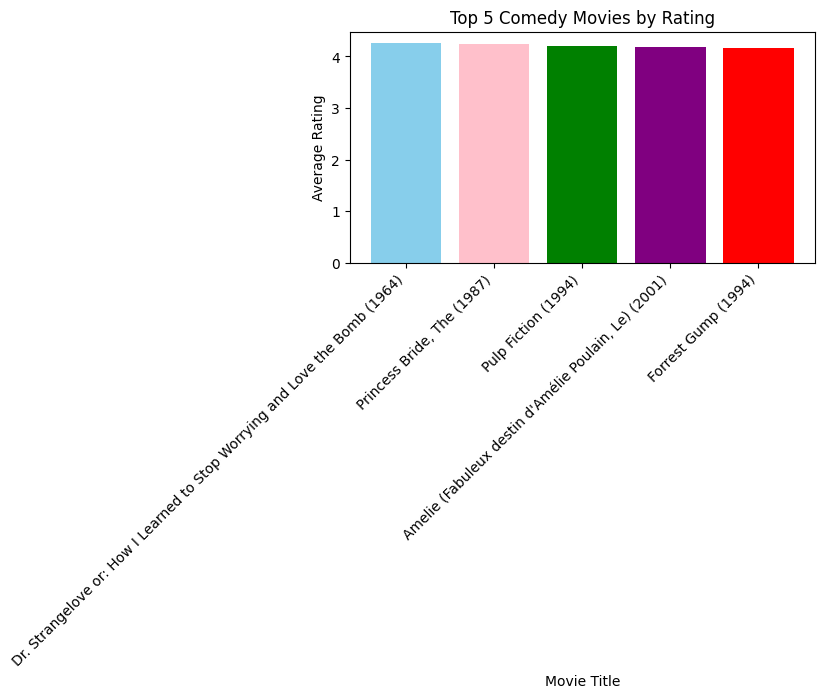

In [17]:
# Get top 5 Comedy movies
top_comedy = recommend_movies_by_genre("Comedy", min_ratings=30, top_n=5)

# Plot vertical bar chart
plt.figure(figsize=(6,3))
plt.bar(top_comedy["title"], top_comedy["mean"], color=['skyblue','pink','green','purple','red'])
plt.xlabel("Movie Title")
plt.ylabel("Average Rating")
plt.title("Top 5 Comedy Movies by Rating")
plt.xticks(rotation=45, ha="right")
plt.show()


# Conclusion:
The chart shows the top 5 comedy movies with the highest average ratings among users with at least 50 ratings. 
These movies are popular choices for comedy fans and are consistently well-rated.


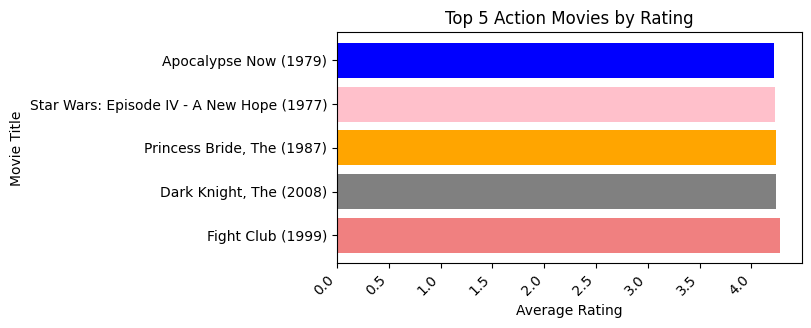

                                          title      mean  count
551                           Fight Club (1999)  4.272936    218
374                     Dark Knight, The (2008)  4.238255    149
1255                 Princess Bride, The (1987)  4.232394    142
1505  Star Wars: Episode IV - A New Hope (1977)  4.231076    251
92                        Apocalypse Now (1979)  4.219626    107


In [18]:
import matplotlib.pyplot as plt

def plot_top_movies_by_genre(genre, min_ratings=30, top_n=5, colors=None):
    # Get top movies from your recommendation function
    top_movies = recommend_movies_by_genre(genre, min_ratings=min_ratings, top_n=top_n)
    
    if top_movies.empty:
        print(f"No movies found in genre '{genre}' with at least {min_ratings} ratings.")
        return
    
    plt.figure(figsize=(6,3))
    
    # Default color palette if none provided
    if colors is None:
        colors = ['skyblue','pink','green','purple','orange']
    
    # Plot vertical bar chart
    plt.barh(top_movies["title"], top_movies["mean"], color=colors[:len(top_movies)])
    plt.ylabel("Movie Title")
    plt.xlabel("Average Rating")
    plt.title(f"Top {top_n} {genre} Movies by Rating")
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # Print the data table
    print(top_movies)


# ✅ Example usage
plot_top_movies_by_genre("Action", min_ratings=50, top_n=5,
                         colors=['lightcoral','grey','orange','pink','blue'])




# Conclusion:
The chart shows the top 5 Action movies with the highest average ratings among users with at least 50 ratings.
    These movies are popular choices for Action fans and are consistently well-rated.


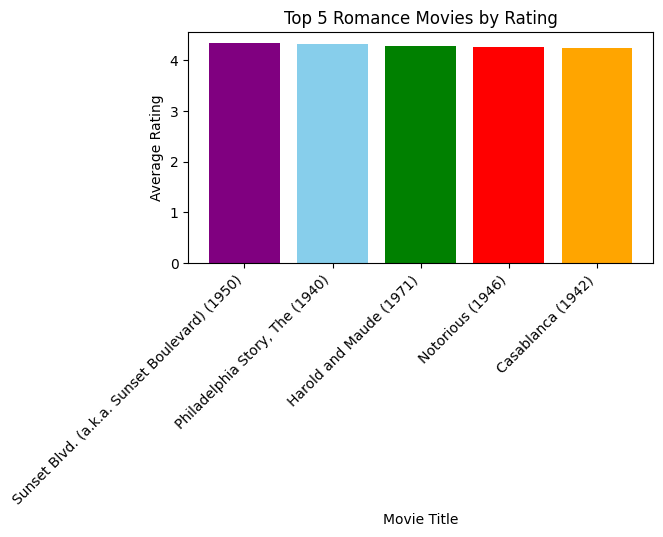

                                              title      mean  count
1356  Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)  4.333333     27
1106                 Philadelphia Story, The (1940)  4.310345     29
588                         Harold and Maude (1971)  4.288462     26
1023                               Notorious (1946)  4.250000     20
265                               Casablanca (1942)  4.240000    100


In [19]:
import matplotlib.pyplot as plt

def plot_top_movies_by_genre(genre, min_ratings=30, top_n=5, colors=None):
    # Get top movies from your recommendation function
    top_movies = recommend_movies_by_genre(genre, min_ratings=min_ratings, top_n=top_n)
    
    if top_movies.empty:
        print(f"No movies found in genre '{genre}' with at least {min_ratings} ratings.")
        return
    
    plt.figure(figsize=(6,3))
    
    # Default color palette if none provided
    if colors is None:
        colors = ['blue','pink','lightcolar','purple','brown']
    
    # Plot vertical bar chart
    plt.bar(top_movies["title"], top_movies["mean"], color=colors[:len(top_movies)])
    plt.xlabel("Movie Title")
    plt.ylabel("Average Rating")
    plt.title(f"Top {top_n} {genre} Movies by Rating")
    plt.xticks(rotation=45, ha="right")
    plt.show()

    # Print the data table
    print(top_movies)

# ✅ Example usage for Romance
plot_top_movies_by_genre("Romance", min_ratings=20, top_n=5,
                         colors=['purple','skyblue','green','red','orange'])



# Conclusion:
The chart shows the top 5 Romance movies with the highest average ratings among users with at least 50 ratings.
These movies are popular choices for Romance fans and are consistently well-rated.


# Machine Learning Extension – Personalized Recommendations
In this step, I applied a basic Machine Learning technique called collaborative filtering.
The system finds users with similar movie rating patterns and recommends movies that those similar users enjoyed.
This makes the recommendations more personalized compared to only showing the most popular movies.

In [21]:
# Create user-movie rating matrix
user_movie_matrix = merged.pivot_table(index='userId', columns='title', values='rating')

# Replace missing values (NaN) with 0
user_movie_matrix_filled = user_movie_matrix.fillna(0)

user_movie_matrix_filled.head()



title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              0.0                                      0.0   
2              0.0                                      0.0   
3              0.0                                      0.0   
4              0.0                                      0.0   
5              0.0                                      0.0   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          0.0                  0.0   
2                          0.0                  0.0   
3                          0.0                  0.0   
4                          0.0                  0.0   
5                          0.0                  0.0   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             0.0                              0.0   
2                             0.0                              0.0   
3                             0.0                              0.0   
4                             0.0                              0.0   
5                             0.0                              0.0   

title   'burbs, The (1989)  'night Mother (1986)  (500) Days of Summer (2009)  \
userId                                                                          
1                      0.0                   0.0                          0.0   
2                      0.0                   0.0                          0.0   
3                      0.0                   0.0                          0.0   
4                      0.0                   0.0                          0.0   
5                      0.0                   0.0                          0.0   

title   *batteries not included (1987)  ...  Zulu (2013)  [REC] (2007)  \
userId                                  ...                              
1                                  0.0  ...          0.0           0.0   
2                                  0.0  ...          0.0           0.0   
3                                  0.0  ...          0.0           0.0   
4                                  0.0  ...          0.0           0.0   
5                                  0.0  ...          0.0           0.0   

title   [REC]² (2009)  [REC]³ 3 Génesis (2012)  \
userId                                           
1                 0.0                      0.0   
2                 0.0                      0.0   
3                 0.0                      0.0   
4                 0.0                      0.0   
5                 0.0                      0.0   

title   anohana: The Flower We Saw That Day - The Movie (2013)  \
userId                                                           
1                                                     0.0        
2                                                     0.0        
3                                                     0.0        
4                                                     0.0        
5                                                     0.0        

title   eXistenZ (1999)  xXx (2002)  xXx: State of the Union (2005)  \
userId                                                                
1                   0.0         0.0                             0.0   
2                   0.0         0.0                             0.0   
3                   0.0         0.0                             0.0   
4                   0.0         0.0                             0.0   
5                   0.0         0.0                             0.0   

title   ¡Three Amigos! (1986)  À nous la liberté (Freedom for Us) (1931)  
userId                                                                    
1                         4.0                                        0.0  
2                         0.0                            

In [22]:
# Compute similarity between users
user_similarity = cosine_similarity(user_movie_matrix_filled)

# Put result into a DataFrame for readability
import pandas as pd
user_sim_df = pd.DataFrame(user_similarity, 
                           index=user_movie_matrix_filled.index, 
                           columns=user_movie_matrix_filled.index)

user_sim_df.head()


userId       1         2         3         4         5         6         7    \
userId                                                                         
1       1.000000  0.027283  0.059720  0.194395  0.129080  0.128152  0.158744   
2       0.027283  1.000000  0.000000  0.003726  0.016614  0.025333  0.027585   
3       0.059720  0.000000  1.000000  0.002251  0.005020  0.003936  0.000000   
4       0.194395  0.003726  0.002251  1.000000  0.128659  0.088491  0.115120   
5       0.129080  0.016614  0.005020  0.128659  1.000000  0.300349  0.108342   

userId       8         9         10   ...       601       602       603  \
userId                                ...                                 
1       0.136968  0.064263  0.016875  ...  0.080554  0.164455  0.221486   
2       0.027257  0.000000  0.067445  ...  0.202671  0.016866  0.011997   
3       0.004941  0.000000  0.000000  ...  0.005048  0.004892  0.024992   
4       0.062969  0.011361  0.031163  ...  0.085938  0.128273  0.307973   
5       0.429075  0.000000  0.030611  ...  0.068048  0.418747  0.110148   

userId       604       605       606       607       608       609       610  
userId                                                                        
1       0.070669  0.153625  0.164191  0.269389  0.291097  0.093572  0.145321  
2       0.000000  0.000000  0.028429  0.012948  0.046211  0.027565  0.102427  
3       0.000000  0.010694  0.012993  0.019247  0.021128  0.000000  0.032119  
4       0.052985  0.084584  0.200395  0.131746  0.149858  0.032198  0.107683  
5       0.258773  0.148758  0.106435  0.152866  0.135535  0.261232  0.060792  

[5 rows x 610 columns]

In [48]:

def recommend_movies_user_based_weighted(user_id, n=5, top_k=10):
    # Get top K similar users (skip self)
    similar_users = user_sim_df[user_id].sort_values(ascending=False).index[1:top_k+1]
    similarities = user_sim_df[user_id].sort_values(ascending=False).values[1:top_k+1]
    
    # Ratings of those users
    movies_rated = user_movie_matrix.loc[similar_users]
    
    # Compute weighted average (users with higher similarity count more)
    weighted_ratings = movies_rated.T.dot(similarities) / similarities.sum()
    
    # Pick top N (drop missing values)
    top_recommendations = weighted_ratings.dropna().sort_values(ascending=False).head(n)
    
    return top_recommendations



In [49]:
# Get recommendations for User 1 with weighted approach
recs = recommend_movies_user_based_weighted(1, n=5, top_k=30)


print("Recommendations for User 1:")
print(recs)



Recommendations for User 1:
title
Star Wars: Episode V - The Empire Strikes Back (1980)    4.514222
Star Wars: Episode IV - A New Hope (1977)                4.461726
Star Wars: Episode VI - Return of the Jedi (1983)        4.168015
dtype: float64


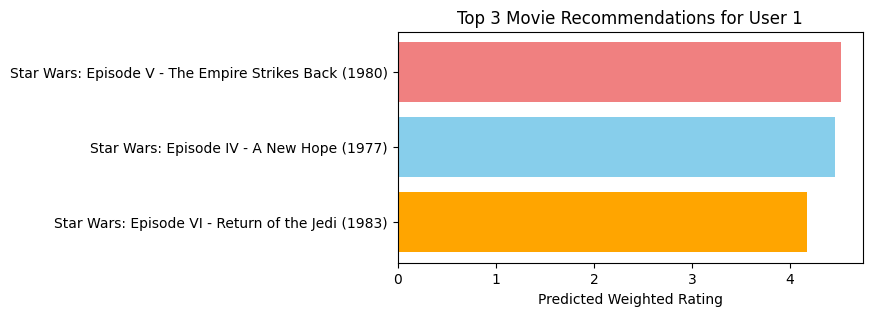

In [51]:
# Plot
plt.figure(figsize=(6,3))
plt.barh(recs.index, recs.values, color=['lightcoral','skyblue','orange','pink'])
plt.xlabel("Predicted Weighted Rating")
plt.title(f"Top {len(recs)} Movie Recommendations for User 1")

plt.gca().invert_yaxis()
plt.show()

# Final Conclusion

#### In this project, we developed a simple movie recommendation system using the MovieLens dataset. The workflow included:
#### ✅Data Cleaning & Preparation – merging and organizing ratings with movie details.
#### ✅Exploratory Analysis – identifying the most popular movies and visualizing genre distributions.
#### ✅Recommendation System –using Machine learning building a user-based approach that suggests movies by finding users with similar preferences.

### Key insights from the analysis:

#### Some movies consistently achieve higher ratings, reflecting strong audience approval.
#### Genres like Drama and Comedy dominate the dataset, showing they are widely enjoyed.
#### Personalized suggestions adapt to each user’s past ratings, providing tailored recommendations.

### This project demonstrates the end-to-end process of building a recommender system — from raw data to meaningful insights and recommendations.